# DELAY SUM - DREGON DATASET

A ideia desse Jupyter é usar o dataset Dregon para aplicar o algoritmo Delay Sum.
Segundo o dataset, http://dregon.inria.fr/datasets/dregon/, as coordenadas X, Y e Z em metros dos oito microfones são:

mic0 = [0.0420, 0.0615, -0.0410]

mic1 = [-0.0420, 0.0615, 0.0410]

mic2 = [-0.0615, 0.0420, -0.0410]

mic3 = [-0.0615, -0.0420, 0.0410]

mic4 = [-0.0420, -0.0615, -0.0410]

mic5 = [0.0420, -0.0615, 0.0410]

mic6 = [0.0615, -0.0420, -0.0410]

mic7 = [0.0615, 0.0420, 0.0410]

Para fazer uma configuração semelhante ao ReSpeaker 4-Mic-Array, vou utilizar apenas quatro microfones com o mesmo valor no eixo Z, mic1, mic3, mic5 e mic7.

In [59]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from math import sqrt as sqrt
import numpy as np

### Importando um áudio qualquer

Segundo o dataset, os áudios são nomeados como se segue:

XX_YY_ZZ.wav where XX denotes the relative azimuth, YY the relative elevation and ZZ the relative distance of the loudspeaker from the array.

O dataset foi gravado com 44100 Hz, e, como o librosa importa os áudios sempre com 22kHz, é preciso colocar sr=None como parâmetro adicional da função abaixo.

In [31]:
originalAudio, freqAmostragem = librosa.load('/home/dimi/Downloads/DREGON_clean_recordings_speech/45_0_1.2__1.wav', sr=None, mono=False)

In [32]:
freqAmostragem

44100

Ouvindo os microfones que serão utilizados (mesmo eixo Z):

In [33]:
Audio(data=originalAudio[1], rate=freqAmostragem)

In [35]:
Audio(data=originalAudio[3], rate=freqAmostragem)

In [36]:
Audio(data=originalAudio[5], rate=freqAmostragem)

In [34]:
Audio(data=originalAudio[7], rate=freqAmostragem)

### Função para verificar o delay entre dois sinais pela correlação

Essa função foi copiada e colada do algoritmo que já havia sido desenvolvido antes. É preciso mandar o argumento maxDelay, que é a quantidade de amostras contidas no maior delay possível entre dois microfones quaisquer.

In [53]:
def verificarDelay(sinalA, sinalB, maxDelay=15, verbose=False):
    
    # Verificando se os dois sinais tem o mesmo tamanho e se maxDelay é compatível
    if len(sinalA) != len(sinalB) or maxDelay >= len(sinalA)-1 :
        return False
    
    # Sei que o maior delay possível (em qtd de amostras) é maxDelay. Portanto, em cada iteração, 
    # a comparação entre os sinais para gerar a correlação se dará com arrays de tamanho 
    # len(sinal) - maxDelay
    tamanho = len(sinalA) - maxDelay
    
    # O delay será a qtd de amostras pra trás ou para frente que há
    # entre o sinal B em relação ao sinal A. Negativo significa que B está adiantado, 0 que não há
    # delay e positivo que está atrasado.
    delay = 0
    melhorCorrelacao = -1
    arrayCorrelacoes = []
    
    inicioA = 0
    fimA    = inicioA + tamanho
    inicioB = len(sinalB) - tamanho
    fimB    = inicioB + tamanho
    
    # Fazendo as iterações e calculando a correlação entre os sinais
    for i in range(-maxDelay, maxDelay+1):
        
        # Calculando a correlação da iteração atual
        corrAtual = np.corrcoef(sinalA[inicioA:fimA], sinalB[inicioB:fimB])[0][1]
        
        # Verificando se encontramos uma correlacao maior ainda para atualizar o delay
        if corrAtual > melhorCorrelacao:
            melhorCorrelacao = corrAtual
            delay = -i
        
        # Printando as iterações se verbose estiver ligado
        if verbose == True:
            arrayCorrelacoes.append(corrAtual)
            plt.title("Delay " + str(i))
            plt.plot(sinalA[inicioA:fimA])
            plt.plot(sinalB[inicioB:fimB])
            plt.show()
            print("Sinal A:", int(inicioA), "até", int(fimA))
            print("Sinal B:", int(inicioB), "até", int(fimB))
            print("Correlação Atual:", corrAtual)
            print("Melhor Correlação:", melhorCorrelacao, "(Delay " + str(delay) + ")\n\n\n")
            
        # Fazendo os indexes dos arrays da próxima iteração. De i = -maxDelay até 0, o Sinal A 
        # fica parado e o Sinal B vem vindo pra trás. A partir de i = 1 até maxDelay, o Sinal B
        # fica parado e o Sinal A vai embora.
        if i < 0:
            inicioB -= 1
            fimB     = inicioB + tamanho
        else:
            inicioA += 1
            fimA     = inicioA + tamanho
         
    # Se o verbose estiver ligado eu printo as correlações em função do delay tb
    if verbose == True:
        plt.title("Correlações em função dos delays")
        plt.plot(arrayCorrelacoes)
        plt.show()
    
    # Retornando o delay
    return delay

A função definirDelayMaximo pode calcular a quantidade de amostras do maior delay possível entre dois microfones. Basta enviar o tamanho do lado do array quadrado.

In [39]:
def definirDelayMaximo(freqAmostragem, L, velocidadeSom=340):
    
    # O delay máximo (em qtd de amostras) dar-se-á na diagonal dos microfones
    diagonal     = sqrt(2 * (L**2))
    tempo        = diagonal / velocidadeSom
    qtdAmostras  = freqAmostragem * tempo
    
    # Adicionando mais 1 amostra pra garantir
    return int(qtdAmostras + 1)

### Verificando o funcionamento da função calculando o delay entre os microfones

A grande cagada é que cada microfone está numa aresta diferente do quadrado. Talvez seja necessário fazer uma troca de base, mas por enquanto da pra calcular o tamanho da aresta de boas.

In [55]:
coordenadasMic1 = [-0.0420, 0.0615]
coordenadasMic3 = [-0.0615, -0.0420]
coordenadasMic5 = [0.0420, -0.0615]
coordenadasMic7 = [0.0615, 0.0420]

vetorLado = [coordenadasMic1[0] - coordenadasMic3[0], coordenadasMic1[1] - coordenadasMic3[1]]
tamanhoLado = sqrt(vetorLado[0]**2 + vetorLado[1]**2)

delayMax = definirDelayMaximo(freqAmostragem, L=tamanhoLado)
print(delayMax)

20


Mostrando como a função faz o cálculo:

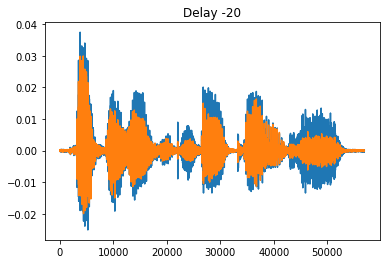

Sinal A: 0 até 56903
Sinal B: 20 até 56923
Correlação Atual: 0.2239138594925863
Melhor Correlação: 0.2239138594925863 (Delay 20)





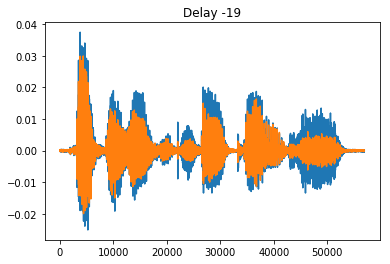

Sinal A: 0 até 56903
Sinal B: 19 até 56922
Correlação Atual: 0.285745902211683
Melhor Correlação: 0.285745902211683 (Delay 19)





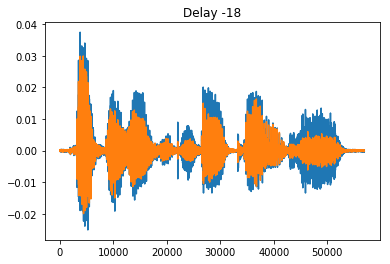

Sinal A: 0 até 56903
Sinal B: 18 até 56921
Correlação Atual: 0.35202572765500906
Melhor Correlação: 0.35202572765500906 (Delay 18)





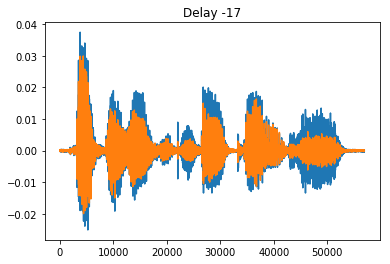

Sinal A: 0 até 56903
Sinal B: 17 até 56920
Correlação Atual: 0.43306491589987833
Melhor Correlação: 0.43306491589987833 (Delay 17)





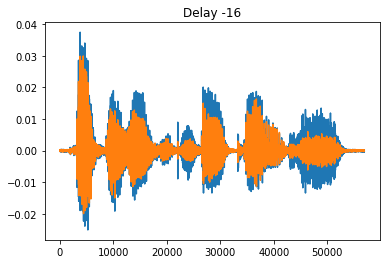

Sinal A: 0 até 56903
Sinal B: 16 até 56919
Correlação Atual: 0.535251614815934
Melhor Correlação: 0.535251614815934 (Delay 16)





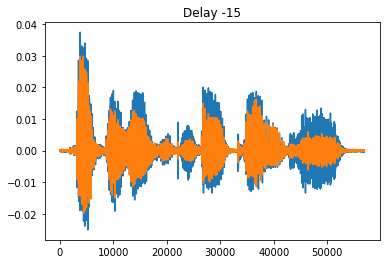

Sinal A: 0 até 56903
Sinal B: 15 até 56918
Correlação Atual: 0.6517760249320833
Melhor Correlação: 0.6517760249320833 (Delay 15)





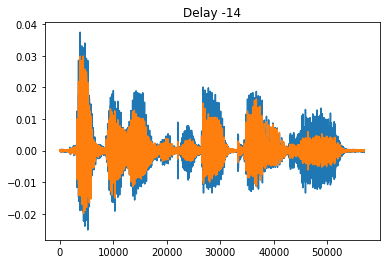

Sinal A: 0 até 56903
Sinal B: 14 até 56917
Correlação Atual: 0.7590204916314296
Melhor Correlação: 0.7590204916314296 (Delay 14)





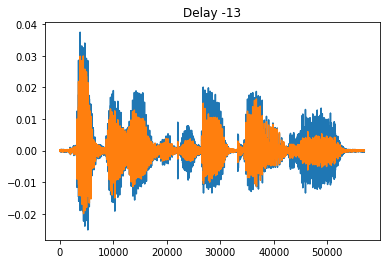

Sinal A: 0 até 56903
Sinal B: 13 até 56916
Correlação Atual: 0.8244264723132188
Melhor Correlação: 0.8244264723132188 (Delay 13)





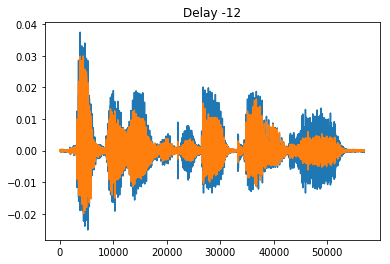

Sinal A: 0 até 56903
Sinal B: 12 até 56915
Correlação Atual: 0.8224986307573449
Melhor Correlação: 0.8244264723132188 (Delay 13)





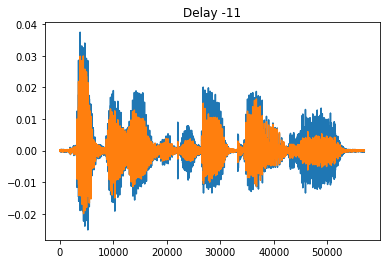

Sinal A: 0 até 56903
Sinal B: 11 até 56914
Correlação Atual: 0.7500242636309594
Melhor Correlação: 0.8244264723132188 (Delay 13)





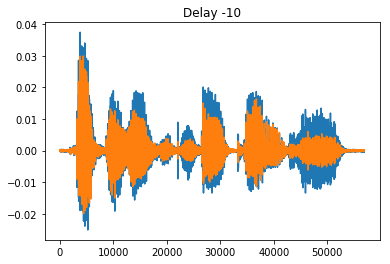

Sinal A: 0 até 56903
Sinal B: 10 até 56913
Correlação Atual: 0.63014107566231
Melhor Correlação: 0.8244264723132188 (Delay 13)





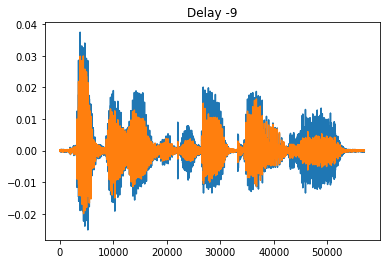

Sinal A: 0 até 56903
Sinal B: 9 até 56912
Correlação Atual: 0.501616836898978
Melhor Correlação: 0.8244264723132188 (Delay 13)





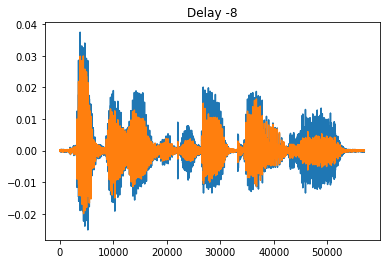

Sinal A: 0 até 56903
Sinal B: 8 até 56911
Correlação Atual: 0.39950886449683487
Melhor Correlação: 0.8244264723132188 (Delay 13)





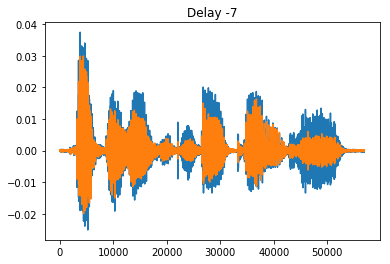

Sinal A: 0 até 56903
Sinal B: 7 até 56910
Correlação Atual: 0.33895837063043327
Melhor Correlação: 0.8244264723132188 (Delay 13)





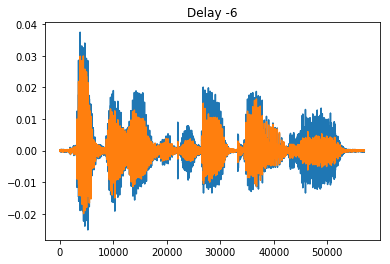

Sinal A: 0 até 56903
Sinal B: 6 até 56909
Correlação Atual: 0.3117629455096576
Melhor Correlação: 0.8244264723132188 (Delay 13)





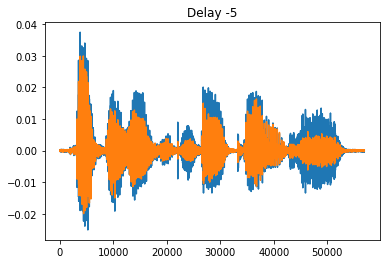

Sinal A: 0 até 56903
Sinal B: 5 até 56908
Correlação Atual: 0.2965635168497762
Melhor Correlação: 0.8244264723132188 (Delay 13)





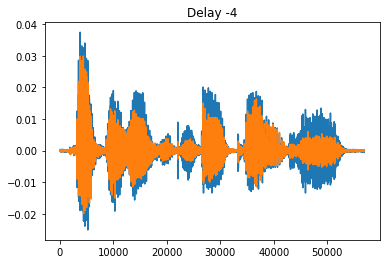

Sinal A: 0 até 56903
Sinal B: 4 até 56907
Correlação Atual: 0.2747449569266956
Melhor Correlação: 0.8244264723132188 (Delay 13)





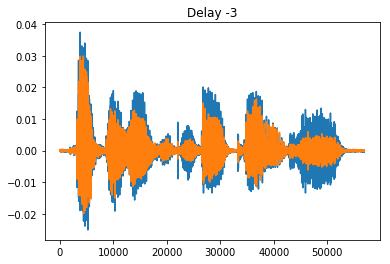

Sinal A: 0 até 56903
Sinal B: 3 até 56906
Correlação Atual: 0.241554230182521
Melhor Correlação: 0.8244264723132188 (Delay 13)





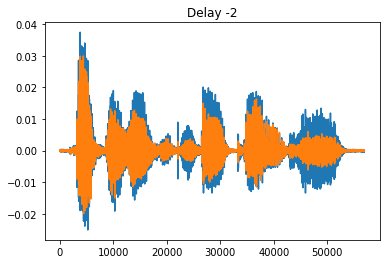

Sinal A: 0 até 56903
Sinal B: 2 até 56905
Correlação Atual: 0.20654062054823327
Melhor Correlação: 0.8244264723132188 (Delay 13)





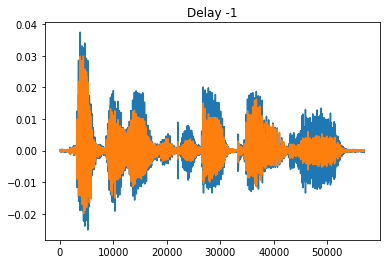

Sinal A: 0 até 56903
Sinal B: 1 até 56904
Correlação Atual: 0.18500183693686814
Melhor Correlação: 0.8244264723132188 (Delay 13)





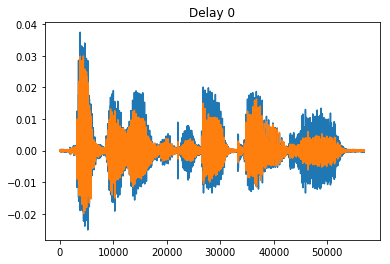

Sinal A: 0 até 56903
Sinal B: 0 até 56903
Correlação Atual: 0.18797331121399088
Melhor Correlação: 0.8244264723132188 (Delay 13)





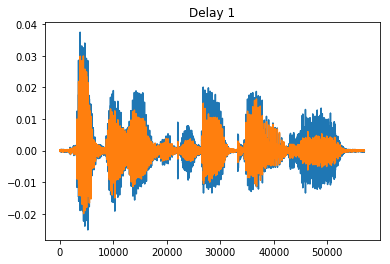

Sinal A: 1 até 56904
Sinal B: 0 até 56903
Correlação Atual: 0.2164458890805372
Melhor Correlação: 0.8244264723132188 (Delay 13)





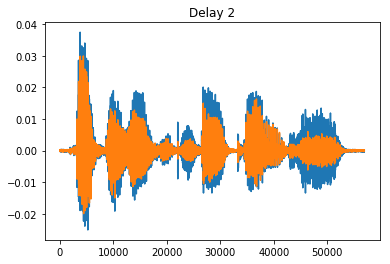

Sinal A: 2 até 56905
Sinal B: 0 até 56903
Correlação Atual: 0.26271810132835466
Melhor Correlação: 0.8244264723132188 (Delay 13)





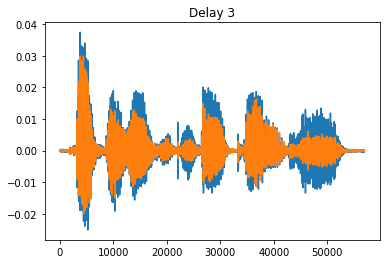

Sinal A: 3 até 56906
Sinal B: 0 até 56903
Correlação Atual: 0.31485887221954295
Melhor Correlação: 0.8244264723132188 (Delay 13)





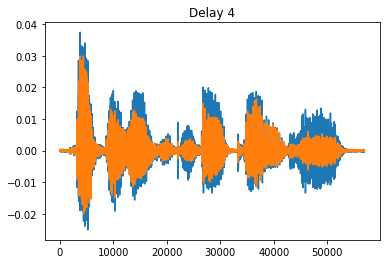

Sinal A: 4 até 56907
Sinal B: 0 até 56903
Correlação Atual: 0.36145996479154296
Melhor Correlação: 0.8244264723132188 (Delay 13)





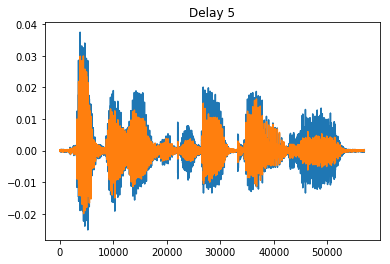

Sinal A: 5 até 56908
Sinal B: 0 até 56903
Correlação Atual: 0.39367457184889854
Melhor Correlação: 0.8244264723132188 (Delay 13)





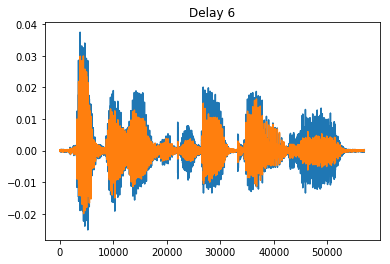

Sinal A: 6 até 56909
Sinal B: 0 até 56903
Correlação Atual: 0.4058079915881608
Melhor Correlação: 0.8244264723132188 (Delay 13)





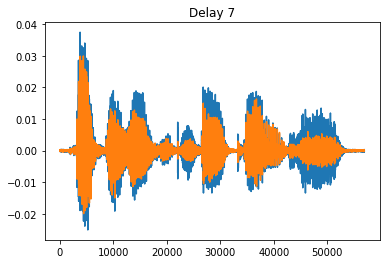

Sinal A: 7 até 56910
Sinal B: 0 até 56903
Correlação Atual: 0.39574666899907723
Melhor Correlação: 0.8244264723132188 (Delay 13)





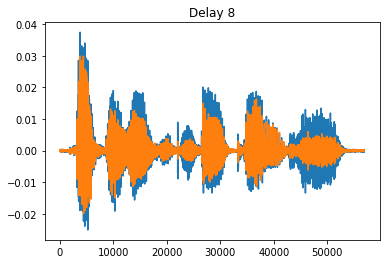

Sinal A: 8 até 56911
Sinal B: 0 até 56903
Correlação Atual: 0.36560512055937855
Melhor Correlação: 0.8244264723132188 (Delay 13)





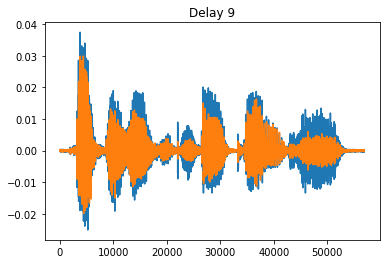

Sinal A: 9 até 56912
Sinal B: 0 até 56903
Correlação Atual: 0.32177254824238816
Melhor Correlação: 0.8244264723132188 (Delay 13)





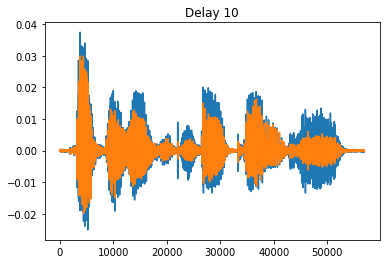

Sinal A: 10 até 56913
Sinal B: 0 até 56903
Correlação Atual: 0.2728259818344319
Melhor Correlação: 0.8244264723132188 (Delay 13)





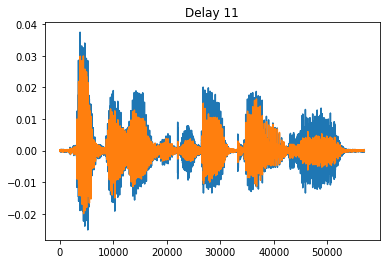

Sinal A: 11 até 56914
Sinal B: 0 até 56903
Correlação Atual: 0.22595943932128706
Melhor Correlação: 0.8244264723132188 (Delay 13)





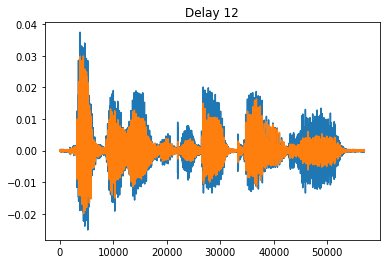

Sinal A: 12 até 56915
Sinal B: 0 até 56903
Correlação Atual: 0.18365837688521183
Melhor Correlação: 0.8244264723132188 (Delay 13)





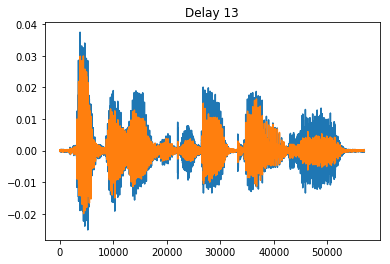

Sinal A: 13 até 56916
Sinal B: 0 até 56903
Correlação Atual: 0.1429303619903846
Melhor Correlação: 0.8244264723132188 (Delay 13)





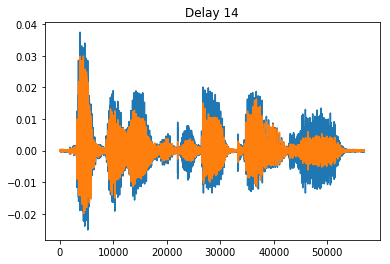

Sinal A: 14 até 56917
Sinal B: 0 até 56903
Correlação Atual: 0.09790600985693666
Melhor Correlação: 0.8244264723132188 (Delay 13)





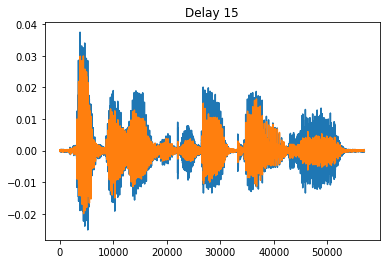

Sinal A: 15 até 56918
Sinal B: 0 até 56903
Correlação Atual: 0.044057190224230276
Melhor Correlação: 0.8244264723132188 (Delay 13)





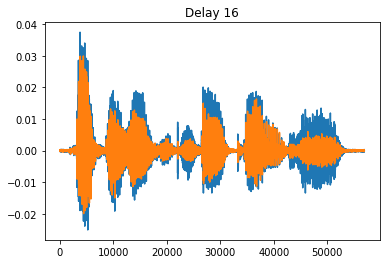

Sinal A: 16 até 56919
Sinal B: 0 até 56903
Correlação Atual: -0.018094768881436046
Melhor Correlação: 0.8244264723132188 (Delay 13)





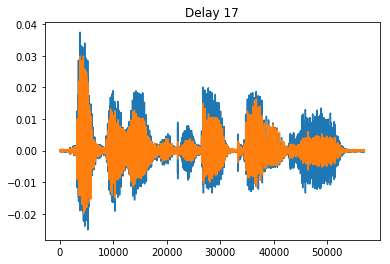

Sinal A: 17 até 56920
Sinal B: 0 até 56903
Correlação Atual: -0.08273267357255176
Melhor Correlação: 0.8244264723132188 (Delay 13)





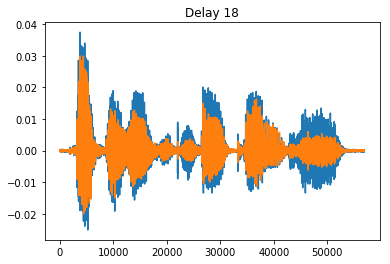

Sinal A: 18 até 56921
Sinal B: 0 até 56903
Correlação Atual: -0.14117734233877588
Melhor Correlação: 0.8244264723132188 (Delay 13)





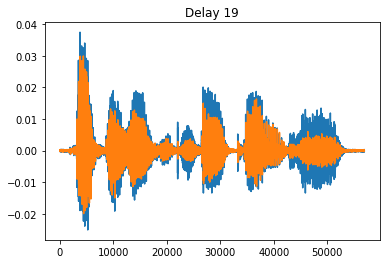

Sinal A: 19 até 56922
Sinal B: 0 até 56903
Correlação Atual: -0.18644478584241547
Melhor Correlação: 0.8244264723132188 (Delay 13)





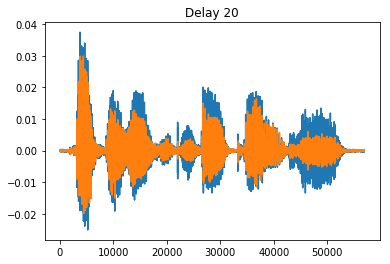

Sinal A: 20 até 56923
Sinal B: 0 até 56903
Correlação Atual: -0.2163088339880479
Melhor Correlação: 0.8244264723132188 (Delay 13)





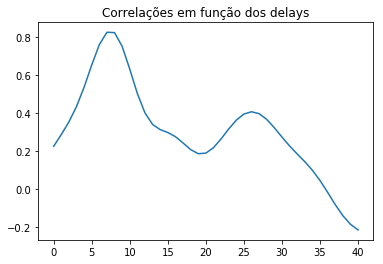

13

In [54]:
verificarDelay(originalAudio[1], originalAudio[3], maxDelay=delayMax, verbose=True)

Calculando o delay entre os microfones tendo o mic1 como referência.

In [56]:
delay13 = verificarDelay(originalAudio[1], originalAudio[3], maxDelay=delayMax)
delay15 = verificarDelay(originalAudio[1], originalAudio[5], maxDelay=delayMax)
delay17 = verificarDelay(originalAudio[1], originalAudio[7], maxDelay=delayMax)

print(delay13)
print(delay15)
print(delay17)

13
5
-8
